In [1]:
from GeneratorEncoderTriplets.encoder.data_processing import ImagesDataset, BalanceSamplerFilled
from GeneratorEncoderTriplets.encoder.loss_module import EPHNLoss
from StarGAN.stargan_v2.core.model import StyleEncoder
import torch
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import pathlib
import time
import os
from matplotlib import pyplot as plt
from sklearn import manifold
import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running device:', DEVICE)

Running device: cuda


In [5]:
train_transforms = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)
train_data_path = pathlib.Path('./StarGAN/hackaton/stargan-v2-experiments/dataset/train/')

eval_transforms = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
)
eval_data_path = pathlib.Path('./StarGAN/hackaton/stargan-v2-experiments/dataset/val/')

In [6]:
len(os.listdir(train_data_path / 'normal')), len(os.listdir(train_data_path / 'cancer')), len(os.listdir(train_data_path / 'covid'))

(375, 505, 289)

In [7]:
len(os.listdir(eval_data_path / 'normal')), len(os.listdir(eval_data_path / 'cancer')), len(os.listdir(eval_data_path / 'covid'))

(41, 56, 32)

In [8]:
encoder_model = StyleEncoder(
    img_size=256,
    style_dim=64,
    num_domains=3
)
# Possibly use pretrained from stargan-v2
encoder_model.to(DEVICE)

N_EPOCHS = 100
N_SIZE = 505
BATCH_SIZE = 128
NUM_WORKERS = 8
criterion = EPHNLoss()
criterion.semi = True
optimizer = optim.SGD(encoder_model.parameters(), lr=0.0005, momentum=0.0)
# Decay after 0.5 (50 in case of 100) * epochs and after 0.75 * epochs (75 in case of 100)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [int(N_EPOCHS * 0.5), int(N_EPOCHS * 0.75)], gamma=0.1)

In [9]:
eval_dataset = ImagesDataset(
    data_path=eval_data_path,
    images_transform=eval_transforms,
    target_transform=None
)
eval_sampler = BalanceSamplerFilled(intervals=eval_dataset.intervals, n_images=56)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, sampler=eval_sampler, num_workers=NUM_WORKERS)
print(len(eval_dataset), len(eval_loader))

129 2


In [16]:
torch.unique(next(iter(eval_loader))[1], return_counts=True), eval_dataset.class_to_idx

((tensor([0, 1, 2]), tensor([44, 45, 39])),
 {'cancer': 0, 'covid': 1, 'normal': 2})

In [18]:
dataset = ImagesDataset(
    data_path=train_data_path,
    images_transform=train_transforms,
    target_transform=None
)
sampler = BalanceSamplerFilled(intervals=dataset.intervals, n_images=N_SIZE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)

In [20]:
dataset.intervals

[[0, 375], [375, 880], [880, 1169]]

In [22]:
start_time = time.time()
global_iterations = 0
for epoch in tqdm(range(N_EPOCHS + 1)): 
    if epoch > 0:
        dataset = ImagesDataset(
            data_path=train_data_path,
            images_transform=train_transforms,
            target_transform=None
        )
        sampler = BalanceSamplerFilled(intervals=dataset.intervals, n_images=N_SIZE)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
        
        encoder_model.train()
 
        # record loss
        train_loss_accum = 0.0

        # iterate batch
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                # Image and its label
                # <FloatTensor> <LongTensor>
                # fvec is encoded vector
                fvec = encoder_model(x_batch, y_batch)
                # Calculate EPHN Triplet NCA loss
                loss, Pos_log, Neg_log, margin = criterion(fvec, y_batch)
                loss.backward()
                optimizer.step() 
            # writer.add_histogram('Pos_hist', Pos_log, global_it)
            # writer.add_histogram('Neg_hist', Neg_log, global_it)
            # writer.add_scalar('Margin', margin, global_it)
            global_iterations += 1

            train_loss_accum += loss.item()
            # N_data += len(y_batch)
            
        # writer.add_scalar('loss', L_data/N_data, epoch)
        # adjust the learning rate
        scheduler.step()
    
        # evaluation phase
        if epoch % 2 == 0:
            encoder_model.eval()
            test_loss_accum = 0.0
            with torch.inference_mode():
                for test_x_batch, test_y_batch in eval_loader:
                    test_x_batch, test_y_batch = test_x_batch.to(DEVICE), test_y_batch.to(DEVICE)
                    test_fvec = encoder_model(test_x_batch, test_y_batch)
                    test_loss, test_Pos_log, test_Neg_log, test_margin = criterion(test_fvec, test_y_batch)
                    test_loss_accum += test_loss.item()
            print(f'Epoch: {epoch} | Train loss: {train_loss_accum / len(loader)} | Test loss: {test_loss_accum / len(eval_loader)}')
end_time = time.time()
print('Total training time:', end_time - start_time)

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 2 | Train loss: 0.00015283511917611273 | Test loss: 0.0001529500659671612
Epoch: 4 | Train loss: 0.00015158627381121428 | Test loss: 0.00015188091492746025
Epoch: 6 | Train loss: 0.0001505202950890331 | Test loss: 0.0001508246859884821
Epoch: 8 | Train loss: 0.00014940014807507396 | Test loss: 0.00014978113176766783
Epoch: 10 | Train loss: 0.0001486258054986441 | Test loss: 0.00014876403292873874
Epoch: 12 | Train loss: 0.00014752166559143612 | Test loss: 0.00014774708688491955
Epoch: 14 | Train loss: 0.00014647132654014663 | Test loss: 0.0001467618130845949
Epoch: 16 | Train loss: 0.00014563506556442007 | Test loss: 0.00014578633272321895
Epoch: 18 | Train loss: 0.00014454211850534193 | Test loss: 0.00014481529797194526
Epoch: 20 | Train loss: 0.00014344798303985348 | Test loss: 0.00014386540715349838
Epoch: 22 | Train loss: 0.0001427236432694675 | Test loss: 0.00014293190906755626
Epoch: 24 | Train loss: 0.00014169681890052743 | Test loss: 0.00014201553130988032
Epoch: 26 | Tr

In [2]:
triplets_encoder_path = pathlib.Path('./StarGAN/hackaton/stargan-v2-experiments/checkpoints/triplets_encoder.pth')
# with open(triplets_encoder_path, 'wb') as file:
#     torch.save(encoder_model.state_dict(), file)

In [24]:
eval_dataset.class_to_idx

{'cancer': 0, 'covid': 1, 'normal': 2}

In [25]:
normal_example = eval_dataset[0]
cancer_example = eval_dataset[50]
covid_example = eval_dataset[100]

normal_example2 = eval_dataset[1]
cancer_example2 = eval_dataset[51]
covid_example2 = eval_dataset[101]

In [26]:
def extract_embedding(example: tuple, model: torch.nn.Module):
    model.eval()
    with torch.inference_mode():
        image, domain = example
        image, domain = image.unsqueeze(dim=0), torch.LongTensor([domain])
        image, label = image.to(DEVICE), domain.to(DEVICE)
        return model(image, domain)

In [27]:
normal_embedding = extract_embedding(normal_example, encoder_model)
cancer_embedding = extract_embedding(cancer_example, encoder_model)
covid_embedding = extract_embedding(covid_example, encoder_model)

In [28]:
normal_embedding2 = extract_embedding(normal_example2, encoder_model)
cancer_embedding2 = extract_embedding(cancer_example2, encoder_model)
covid_embedding2 = extract_embedding(covid_example2, encoder_model)

In [29]:
torch.sqrt(torch.sum((normal_embedding - cancer_embedding) ** 2))

tensor(0.2810, device='cuda:0')

In [30]:
torch.sqrt(torch.sum((covid_embedding - covid_embedding2) ** 2))

tensor(0.0065, device='cuda:0')

In [3]:
!nvidia-smi

Fri Nov  4 09:43:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:8B:00.0 Off |                    0 |
| N/A   30C    P0    35W / 250W |  26765MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
with torch.inference_mode():
    encoder_model.load_state_dict(torch.load(triplets_encoder_path))
    domains = []
    embeddings = []
    encoder_model.eval()
    for x_batch, y_batch in eval_loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        f_vectors = encoder_model(x_batch, y_batch)
        domains += y_batch.tolist()
        embeddings.append(f_vectors.cpu())
    embeddings = torch.concat(embeddings, dim=0)

In [13]:
tsne = manifold.TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(embeddings)

/home/natitov/miniforge/envs/hack_lct/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/natitov/miniforge/envs/hack_lct/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [21]:
eval_dataset.class_to_idx

{'cancer': 0, 'covid': 1, 'normal': 2}

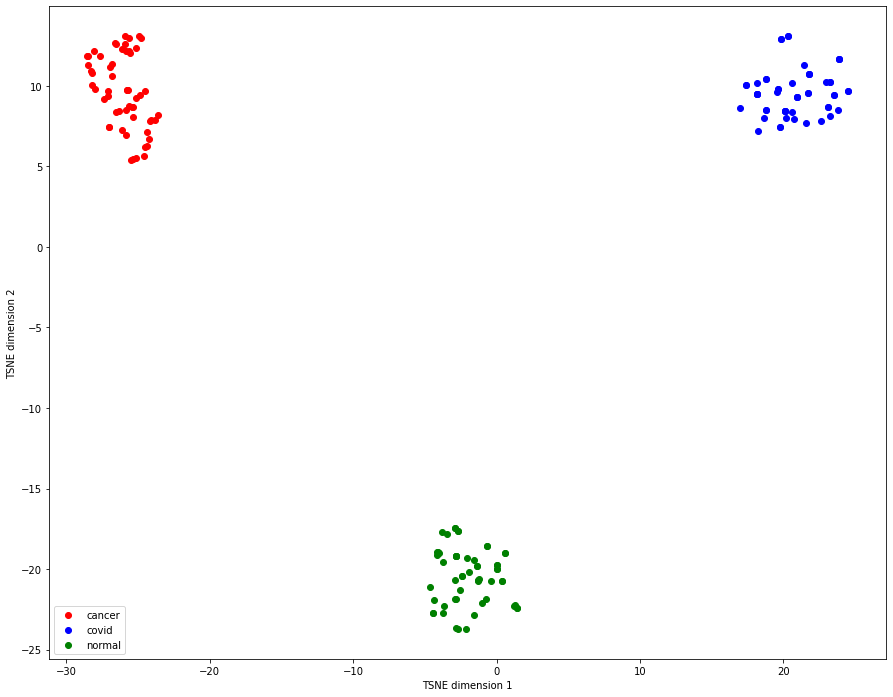

In [28]:
plt.figure(figsize=(15, 12))
domains = np.array(domains)
plt.scatter(tsne_embeddings[domains == 0][:, 0], tsne_embeddings[domains == 0][:, 1], c='red', label='cancer')
plt.scatter(tsne_embeddings[domains == 1][:, 0], tsne_embeddings[domains == 1][:, 1], c='blue', label='covid')
plt.scatter(tsne_embeddings[domains == 2][:, 0], tsne_embeddings[domains == 2][:, 1], c='green', label='normal')
plt.xlabel('TSNE dimension 1')
plt.ylabel('TSNE dimension 2')
plt.legend()
plt.grid(False);

In [19]:
tsne_embeddings

array([[-3.67208672e+00, -2.22681160e+01],
       [ 1.74087315e+01,  1.00354643e+01],
       [-2.70875149e+01,  9.35823250e+00],
       [-2.57867565e+01,  9.75229931e+00],
       [-2.42539349e+01,  6.72838354e+00],
       [-4.13985682e+00, -1.91270199e+01],
       [-2.43515606e+01,  6.24696922e+00],
       [ 1.82698174e+01,  7.22058630e+00],
       [-2.56041718e+01,  1.21430750e+01],
       [-2.70236626e+01,  7.45125008e+00],
       [-2.58794174e+01,  6.94333744e+00],
       [-2.45357800e+01,  6.20176935e+00],
       [-4.43810844e+00, -2.27065887e+01],
       [-2.53577862e+01,  5.44733047e+00],
       [-2.57371464e+01,  9.75529575e+00],
       [-2.82927918e+00, -2.18717670e+01],
       [ 1.96330585e+01,  9.77343845e+00],
       [-2.56086483e+01,  1.29400816e+01],
       [-2.48307686e+01,  1.29412889e+01],
       [ 2.45384579e+01,  9.70445442e+00],
       [-2.82441282e+00, -1.92013092e+01],
       [ 1.97504349e+01,  7.42225695e+00],
       [-1.26328170e+00, -2.07113438e+01],
       [-4.